In [1]:
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import glob
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as T
import segmentation_models_pytorch as smp
from tqdm import tqdm

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
val = glob.glob('/workspace/jay/DDP/Ocelot/yolo_binary/datasets/cell_detect_33-1/valid/images/*.jpg')
test = glob.glob('/workspace/jay/DDP/Ocelot/yolo_binary/datasets/cell_detect_33-1/test/images/*.jpg')
val_files = np.unique(np.array([x.split('/')[-1][:3] for x in val]))
test_files = np.unique(np.array([x.split('/')[-1][:3] for x in test]))
val_set = list(val_files)+list(test_files)

In [3]:
class Ocelot(Dataset):
    def __init__(self):
        self.tissue_imgs = glob.glob('/workspace/jay/DDP/Ocelot/ocelot2023/images/train/tissue/*.jpg')
        #self.tissue_imgs = [x for x in temp if x.split('/')[-1][:3] not in val_set]
        
    def __len__(self): 
        return len(self.tissue_imgs)

    def __getitem__(self, idx):
        
        tissue_name = self.tissue_imgs[idx]
        tissue_annot = tissue_name.replace('images','annotations')
        tissue_annot = tissue_annot.replace('jpg','png')
        
        tissue = Image.open(tissue_name)
        #tissue = transforms(tissue)
        
        annot = np.array(Image.open(tissue_annot))
        label = np.zeros((3,annot.shape[0],annot.shape[1]))
        label[0][np.where(annot==1)] = 1
        label[1][np.where(annot==2)] = 1
        label[2][np.where(annot==255)] = 1
        label = torch.Tensor(label)
        
        if random.uniform(0, 1)>0.5:
            tissue = T.functional.hflip(tissue)
            label = T.functional.hflip(label)
        rot = random.uniform(0,1)
        if rot<0.5 and rot>=0.25:
            tissue = T.functional.rotate(tissue,angle=90)
            label = T.functional.rotate(label,angle=90)
        elif rot>=0.5 and rot<0.75:
            tissue = T.functional.rotate(tissue,angle=180)
            label = T.functional.rotate(label,angle=180)
        elif rot>=0.75 and rot<=1:
            tissue = T.functional.rotate(tissue,angle=270)
            label = T.functional.rotate(label,angle=270)

        tissue = np.array(tissue)
        tissue = tissue / 255
        tissue = tissue - 0.5
        tissue = torch.Tensor(np.moveaxis(tissue, -1, 0))
            
        return tissue,label,self.tissue_imgs[idx]
        

In [4]:
# ds = Ocelot()
# dl = DataLoader(ds, batch_size=1, shuffle=True, num_workers=1)

In [5]:
device = 'cuda:2'

model = smp.DeepLabV3Plus(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_depth=5,
    encoder_weights='imagenet',     # use `imagenet` pre-trained weights for encoder initialization
    activation=None,
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)

In [6]:
batch_size = 32
model = model.to(device)
ds = Ocelot()
dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=3)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [7]:
model = model.train()
num_iter = 0
best_loss = float('inf')
for epoch in (range(50)):
    total_loss = 0
    for tissue,mask,_ in tqdm(dl):
        optimizer.zero_grad()
        image = tissue.to(device)
        mask = (mask.float()).to(device)
        out = model(image)
        loss = criterion(out, mask)
        total_loss += loss
        loss.backward()
        optimizer.step()

    print(f'{epoch} -- {total_loss/batch_size:.3f}')
    if total_loss<best_loss:
        torch.save(model, f'/workspace/jay/DDP/Ocelot/tissue_seg/sub_ckpts/{epoch}_{total_loss/batch_size:.3f}.pt')
        best_loss = total_loss
    scheduler.step()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:15<00:00,  1.22s/it]


0 -- 0.335


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:15<00:00,  1.19s/it]


1 -- 0.231


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.14s/it]


2 -- 0.198


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.12s/it]


3 -- 0.181


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.12s/it]


4 -- 0.164


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.13s/it]


5 -- 0.162


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.15s/it]


6 -- 0.147


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.11s/it]


7 -- 0.143


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.11s/it]


8 -- 0.135


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.13s/it]


9 -- 0.132


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:16<00:00,  1.26s/it]


10 -- 0.115


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:16<00:00,  1.27s/it]


11 -- 0.118


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:15<00:00,  1.15s/it]


12 -- 0.113


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.15s/it]


13 -- 0.109


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.15s/it]


14 -- 0.111


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.13s/it]


15 -- 0.108


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:15<00:00,  1.16s/it]


16 -- 0.113


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.15s/it]


17 -- 0.105


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/it]


18 -- 0.105


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/it]


19 -- 0.105


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/it]


20 -- 0.095


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/it]


21 -- 0.093


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/it]


22 -- 0.095


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.15s/it]


23 -- 0.090


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:15<00:00,  1.16s/it]


24 -- 0.088


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.13s/it]


25 -- 0.091


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:15<00:00,  1.16s/it]


26 -- 0.092


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.14s/it]


27 -- 0.088


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/it]


28 -- 0.093


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/it]


29 -- 0.091


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.11s/it]


30 -- 0.087


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:15<00:00,  1.16s/it]


31 -- 0.086


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:15<00:00,  1.16s/it]


32 -- 0.085


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.11s/it]


33 -- 0.086


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.15s/it]


34 -- 0.084


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.14s/it]


35 -- 0.084


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.15s/it]


36 -- 0.092


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.12s/it]


37 -- 0.082


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/it]


38 -- 0.084


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.14s/it]


39 -- 0.087


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.14s/it]


40 -- 0.081


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/it]


41 -- 0.080


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/it]


42 -- 0.085


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.10s/it]


43 -- 0.081


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:15<00:00,  1.18s/it]


44 -- 0.081


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.12s/it]


45 -- 0.081


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/it]


46 -- 0.084


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.09s/it]


47 -- 0.080


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.13s/it]


48 -- 0.081


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:14<00:00,  1.13s/it]

49 -- 0.085


In [8]:
out.shape

torch.Size([32, 3, 1024, 1024])

In [9]:
mask.shape

torch.Size([32, 3, 1024, 1024])

In [10]:
tissue,annot,name = next(iter(dl))
print(tissue.shape)

torch.Size([32, 3, 1024, 1024])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


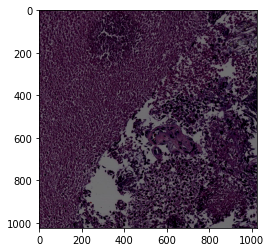

In [11]:
plt.imshow(np.moveaxis(np.array(tissue[0]),0,-1))

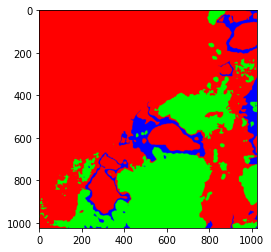

In [12]:
plt.imshow(np.moveaxis(np.array(annot[0]),0,-1))

In [13]:
annot[0].shape

torch.Size([3, 1024, 1024])

In [14]:
tissue[0].shape

torch.Size([3, 1024, 1024])

In [15]:
name

('/workspace/jay/DDP/Ocelot/ocelot2023/images/train/tissue/232.jpg',
 '/workspace/jay/DDP/Ocelot/ocelot2023/images/train/tissue/353.jpg',
 '/workspace/jay/DDP/Ocelot/ocelot2023/images/train/tissue/044.jpg',
 '/workspace/jay/DDP/Ocelot/ocelot2023/images/train/tissue/305.jpg',
 '/workspace/jay/DDP/Ocelot/ocelot2023/images/train/tissue/330.jpg',
 '/workspace/jay/DDP/Ocelot/ocelot2023/images/train/tissue/234.jpg',
 '/workspace/jay/DDP/Ocelot/ocelot2023/images/train/tissue/086.jpg',
 '/workspace/jay/DDP/Ocelot/ocelot2023/images/train/tissue/151.jpg',
 '/workspace/jay/DDP/Ocelot/ocelot2023/images/train/tissue/052.jpg',
 '/workspace/jay/DDP/Ocelot/ocelot2023/images/train/tissue/278.jpg',
 '/workspace/jay/DDP/Ocelot/ocelot2023/images/train/tissue/036.jpg',
 '/workspace/jay/DDP/Ocelot/ocelot2023/images/train/tissue/284.jpg',
 '/workspace/jay/DDP/Ocelot/ocelot2023/images/train/tissue/137.jpg',
 '/workspace/jay/DDP/Ocelot/ocelot2023/images/train/tissue/105.jpg',
 '/workspace/jay/DDP/Ocelot/ocelot

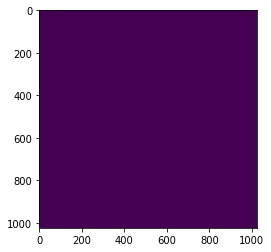

In [37]:
plt.imshow(label[2])